# ACE estimations from generated RCT data
*This notebook examines the use of the `CausalEffectEstimation` module for estimating Average Causal Effects (ACE) in Randomized Controlled Trials (RCTs) within the Neyman-Rubin potential outcome framework from generated data.*

In [20]:
import pyAgrum as gum
import pyAgrum.lib.discretizer as disc

import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb

import numpy as np
import pandas as pd

Consider two generative models:

* A linear generative model described by the equation:
$$ Y = 3X_1 + 2X_2 -2X_3 -0.8X_4 + T(2X_1 + 5X_3 +3X_4) $$

* And a non-linear generative model described by the equation:
$$ Y = 3X_1 + 2X_2^2 -2X_3 -0.8X_4 +10T $$


Where $ (X_1,X_2,X_3,X_4) \sim \mathcal{N}_4((1,1,1,1), I_4) $, $T \sim \mathcal{Ber}(1/2)$ and $ (X_1,X_2,X_3,X_4,T) $ are jointly independent in both of the models.

Data from the models can be obtatined by the functions given below.

In [2]:
def linear_simulation(n : int = 100000, sigma : float = 1) -> pd.DataFrame:
  """
  Returns n observations from the linear model with normally distributed
  noise with expected value 0 and standard deviation sigma.
  """

  X1 = np.random.normal(1, 1, n)
  X2 = np.random.normal(1, 1, n)
  X3 = np.random.normal(1, 1, n)
  X4 = np.random.normal(1, 1, n)
  epsilon = np.random.normal(0, sigma, n)
  T=np.random.binomial(1, 0.5, n)
  Y= 3*X1+2*X2-2*X3-0.8*X4+T*(2*X1+5*X3+3*X4)+epsilon
  d=np.array([T,X1,X2,X3,X4,Y])
  df_data = pd.DataFrame(data=d.T,columns=['T','X1','X2','X3','X4','Y'])
  df_data["T"] = df_data["T"].astype(int)

  return df_data

def non_linear_simulation(n : int = 100000, sigma : float = 1) -> pd.DataFrame:
  """
  Returns n observations from the non-linear model with normally distributed
  noise with expected value 0 and standard deviation sigma.
  """

  X1 = np.random.normal(1, 1, n)
  X2 = np.random.normal(1, 1, n)
  X3 = np.random.normal(1, 1, n)
  X4 = np.random.normal(1, 1, n)
  epsilon = np.random.normal(0, sigma, n)
  T=np.random.binomial(1, 0.5, n)
  Y= 3*X1+ 2*X2**2-2*X3-0.8*X4+10*T+epsilon
  d=np.array([T,X1,X2,X3,X4,Y])
  df_data = pd.DataFrame(data=d.T,columns=['T','X1','X2','X3','X4','Y'])
  df_data["T"] = df_data["T"].astype(int)

  return df_data

Furthermore, the expected values of $Y(0)$ and $Y(1)$ can be explicitly calculated, providing us the theoretical ACE of $\tau = 10$ which will serve as a point of reference for the estimations.

We will explore how the `CausalEffectEstimation` module can estimate the causal effect of $T$ on $Y$ in both of the generated datasets.

### Setup

First, genereate the data using the previously defined functions, and specify the causal graph of the variables. A single graph will be applicable to both datasets, as they share the same variables and causal structure.

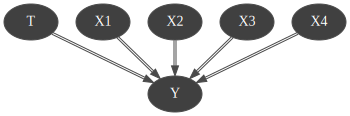

In [3]:
linear_data = linear_simulation()
non_linear_data = non_linear_simulation()

bn = gum.fastBN("Y<-T; Y<-X1; Y<-X2; Y<-X3; Y<-X4")
causal_model = csl.CausalModel(bn)

cslnb.showCausalModel(causal_model, size="10")

If the `CausalBNEstimator` estimation method is not employed for estimation process, the model generated using `gum.fastBN` will suffice, as only the graph structure of the Causal Bayesian Network will be used for causal identification.

However, if the Causal Bayesian Network estimator is utilized, it will be necessary to provide a `csl.CausalModel` object with appropriate discretization, as the Conditional Probability Tables of the model will be used for estimation. Here we use the `discretizer` module to perform this task, the arcs are added manually.

Selecting an optimal discretization is crucial: a coarse discretization may lead to poor estimation due to its inability to capture fine variations in the distribution, while an overly fine discretization may result in too many parameters, making it difficult for the parameter learning algorithm to accurately estimate the distribution. Therefore, the discretization should strike a balance, being neither too coarse nor too fine.

In [21]:
discretizer = disc.Discretizer(
    defaultDiscretizationMethod="uniform",
    defaultNumberOfBins=20
)
disc_bn = discretizer.discretizedTemplate(linear_data)

disc_bn.beginTopologyTransformation()
for node in {"T", "X1", "X2", "X3", "X4"}:
    disc_bn.addArc(node, "Y")
disc_bn.endTopologyTransformation()

disc_causal_model = csl.CausalModel(disc_bn)

for id, _ in disc_bn:
    print(disc_bn.variable(id))

T:Range([0,1])
X1:Discretized(<(-3.22022;-2.80456[,[-2.80456;-2.38891[,[-2.38891;-1.97325[,[-1.97325;-1.55759[,[-1.55759;-1.14194[,[-1.14194;-0.72628[,[-0.72628;-0.310623[,[-0.310623;0.105035[,[0.105035;0.520692[,[0.520692;0.936349[,[0.936349;1.35201[,[1.35201;1.76766[,[1.76766;2.18332[,[2.18332;2.59898[,[2.59898;3.01463[,[3.01463;3.43029[,[3.43029;3.84595[,[3.84595;4.26161[,[4.26161;4.67726[,[4.67726;5.09292)>)
X2:Discretized(<(-3.43071;-3.00632[,[-3.00632;-2.58193[,[-2.58193;-2.15755[,[-2.15755;-1.73316[,[-1.73316;-1.30878[,[-1.30878;-0.884392[,[-0.884392;-0.460006[,[-0.460006;-0.0356202[,[-0.0356202;0.388766[,[0.388766;0.813151[,[0.813151;1.23754[,[1.23754;1.66192[,[1.66192;2.08631[,[2.08631;2.51069[,[2.51069;2.93508[,[2.93508;3.35947[,[3.35947;3.78385[,[3.78385;4.20824[,[4.20824;4.63262[,[4.63262;5.05701)>)
X3:Discretized(<(-4.56399;-4.06937[,[-4.06937;-3.57475[,[-3.57475;-3.08013[,[-3.08013;-2.58551[,[-2.58551;-2.09089[,[-2.09089;-1.59627[,[-1.59627;-1.10165[,[-1.10165;-0.607032[,

We are now prepared to instantiate the `CausalEffectEstimation` object for both datasets.

In [8]:
linear_cee = csl.CausalEffectEstimation(linear_data, disc_causal_model)
print(linear_cee)


 Dataframe	: <pandas.core.frame.DataFrame object at 0x7cff555ad0f0>
	- shape		: (100000, 6)
	- columns	: Index(['T', 'X1', 'X2', 'X3', 'X4', 'Y'], dtype='object')
	- memory usage	: 4.800128 MB
 Causal Model	: <pyAgrum.causal._CausalModel.CausalModel object at 0x7cfece518af0>
	- names		: {0: 'T', 1: 'X1', 2: 'X2', 3: 'X3', 4: 'X4', 5: 'Y'}
	- causal BN	: BN{nodes: 6, arcs: 5, domainSize: 10^6.80618, dim: 6080077, mem: 48Mo 848Ko 656o}
	- observ. BN	: BN{nodes: 6, arcs: 5, domainSize: 10^6.80618, dim: 6080077, mem: 48Mo 848Ko 656o}


In [9]:
non_linear_cee = csl.CausalEffectEstimation(non_linear_data, disc_causal_model)
print(non_linear_cee)


 Dataframe	: <pandas.core.frame.DataFrame object at 0x7cff555ae890>
	- shape		: (100000, 6)
	- columns	: Index(['T', 'X1', 'X2', 'X3', 'X4', 'Y'], dtype='object')
	- memory usage	: 4.800128 MB
 Causal Model	: <pyAgrum.causal._CausalModel.CausalModel object at 0x7cfece518af0>
	- names		: {0: 'T', 1: 'X1', 2: 'X2', 3: 'X3', 4: 'X4', 5: 'Y'}
	- causal BN	: BN{nodes: 6, arcs: 5, domainSize: 10^6.80618, dim: 6080077, mem: 48Mo 848Ko 656o}
	- observ. BN	: BN{nodes: 6, arcs: 5, domainSize: 10^6.80618, dim: 6080077, mem: 48Mo 848Ko 656o}


### Causal Indentification

The subsequent step involves identifying the causal criterion to be used for estimation. This is crucial, as most estimators rely on strong assumptions regarding the underlying causal structure of the data-generating process. Incorrect specification of the adjustment may compromise the guarantee of asymptotic normality.

In [33]:
linear_cee.identifyAdjustmentSet(intervention="T", outcome="Y")
non_linear_cee.identifyAdjustmentSet(intervention="T", outcome="Y", verbose=False)

Randomized Controlled Trial adjustment found. 

Supported estimators include:
- CausalModelEstimator
- DM
If the outcome variable is a cause of other covariates in the causal graph,
Backdoor estimators may also be used.


'Randomized Controlled Trial'

Consistent with the data generation, the adjustment identified is the Randomized Control Trial adjustment. This yields a list of the various estimators supported by this adjustment.

### Causal Effect Estimation
Once the adjustment is identified, we can proceed to estimation using the supported estimators. First, the estimator must be fitted to the data.

In [34]:
linear_cee.fitDM()
non_linear_cee.fitDM()

The estimation is obtained by calling the `estimateCausalEffect` method.

In [35]:
linear_tau_hat = linear_cee.estimateCausalEffect()
non_linear_tau_hat = non_linear_cee.estimateCausalEffect()

print(f"ACE linear = {linear_tau_hat}, MAPE = {abs((linear_tau_hat-10)*10)} %")
print(f"ACE non linear = {non_linear_tau_hat}, MAPE = {abs((non_linear_tau_hat-10)*10)} %")

ACE linear = 9.97466438117557, MAPE = 0.2533561882443003 %
ACE non linear = 10.008543335476592, MAPE = 0.08543335476591807 %


The difference-in-means estimator, which is the simplest estimator for the ACE, yields mostly accurate results. This is expected in an RCT environment where the treatment is independent of confounders, making intervention equivalent to observation.

# User specified adjustment

If the user wish to apply an alternative adjustment, they may specify their own set of variables for each component of the adjustment. However, please note that such custom adjustments do not guarantee unbiased estimation and may not ensure an error-free estimation process.

In [10]:
linear_cee.useBackdoorAdjustment(intervention="T", outcome="Y", confounders={"X1", "X2", "X3", "X4"})
non_linear_cee.useBackdoorAdjustment(intervention="T", outcome="Y", confounders={"X1", "X2", "X3", "X4"})

In [11]:
linear_cee.fitSLearner()
non_linear_cee.fitSLearner()

In [12]:
linear_tau_hat = linear_cee.estimateCausalEffect()
non_linear_tau_hat = non_linear_cee.estimateCausalEffect()

print(f"ACE linear = {linear_tau_hat}, MAPE = {abs((linear_tau_hat-10)*10)} %")
print(f"ACE non linear = {non_linear_tau_hat}, MAPE = {abs((non_linear_tau_hat-10)*10)} %")

ACE linear = 10.002834758330295, MAPE = 0.028347583302945623 %
ACE non linear = 10.021782570833382, MAPE = 0.2178257083338231 %


In this case, RCT adjustment also supports Backdoor adjustment, we thus get mostly accurate estimations. Let's see how the estimation would be if we specify an uncompatible adjustment.

### Incorrectly specified adjustment

We will use the frontdoor adjustment to illustrate the behaviours of incorrect specification. 

In [13]:
linear_cee.useFrontdoorAdjustment(intervention="T", outcome="Y", mediators={"X1", "X2", "X3", "X4"})
non_linear_cee.useFrontdoorAdjustment(intervention="T", outcome="Y", mediators={"X1", "X2", "X3", "X4"})

In [14]:
linear_cee.fitSimplePlugIn()
non_linear_cee.fitSimplePlugIn()

In [15]:
linear_tau_hat = linear_cee.estimateCausalEffect()
non_linear_tau_hat = non_linear_cee.estimateCausalEffect()

print(f"ACE linear = {linear_tau_hat}, MAPE = {abs((linear_tau_hat-10)*10)} %")
print(f"ACE non linear = {non_linear_tau_hat}, MAPE = {abs((non_linear_tau_hat-10)*10)} %")

ACE linear = -0.061501388720017765, MAPE = 100.61501388720018 %
ACE non linear = -0.05234306429917344, MAPE = 100.52343064299173 %


As anticipated, using an incorrect adjustment set results in a heavily biased estimation. In this case, the ACE is close to zero, indicating that the estimator incorrectly predicts no causal effect of $T$ on $Y$.

### Causal Bayesian Network Estimation

To fully utilize the causal model within the estimation process, we will now use the Conditional Probability Tables of the Causal Bayesian Network via the `CausalBNEstimator`, rather than relying solely on the underlying causal graph. The procedure will follow the same methodology as previously applied.

In [16]:
linear_cee.identifyAdjustmentSet(intervention="T", outcome="Y", verbose=False)
non_linear_cee.identifyAdjustmentSet(intervention="T", outcome="Y", verbose=False)

'Randomized Controlled Trial'

In [17]:
linear_cee.fitCausalBNEstimator()
non_linear_cee.fitCausalBNEstimator()

In [18]:
linear_tau_hat = linear_cee.estimateCausalEffect()
non_linear_tau_hat = non_linear_cee.estimateCausalEffect()

print(f"ACE linear = {linear_tau_hat}, MAPE = {abs((linear_tau_hat-10)*10)} %")
print(f"ACE non linear = {non_linear_tau_hat}, MAPE = {abs((non_linear_tau_hat-10)*10)} %")

ACE linear = 8.990226527952546, MAPE = 10.097734720474545 %
ACE non linear = 8.981047882072367, MAPE = 10.189521179276326 %
